<a href="https://colab.research.google.com/github/TAEWOOYOON/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_03_Generative_Model_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.03 Generative Model - DCGAN

* 날짜: 2022.08.09
* 이름: 윤태우

## 학습내용
    - 딥러닝 생성모델에 대해 이해한다.
    - Deep Convolutional Generative Adversarial Networks 를 구현한다.

> https://arxiv.org/pdf/1406.2661.pdf



## 실습
---

### | **모델 구현**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-02.PNG?raw=true' width=800>
</p>

In [25]:
# Generator

import tensorflow as tf
from tensorflow.keras import models, layers, utils
def build_generator(z_dim = 64, img_shape = (28,28,1)) :
  h,w,c = img_shape
  z = layers.Input(shape = [z_dim]) # 길이가 z_dim인 벡터
  y = layers.Dense(int(w/4)*int(h/4)*128)(z)
  y = layers.Reshape([int(w/4),int(h/4),128])(y)

  y = layers.BatchNormalization()(y)
  y = layers.Conv2DTranspose(64,kernel_size = 5, padding = 'same', strides = 2, activation = 'relu')(y)
  y = layers.BatchNormalization()(y)
  y = layers.Conv2DTranspose(c,kernel_size = 5, padding = 'same', strides = 2, activation = 'sigmoid')(y)
  return models.Model(z, y, name = 'Generator')

g = build_generator(128,(32,32,3))
g.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_7 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_5 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 16, 16, 64)       204864    
 Transpose)                                                      
                                                                 
 batch_normalization_11 (Bat  (None, 16, 16, 64)       25

In [26]:
# Discriminator

def build_discriminator(img_shape = (28,28,1)) :
  x = layers.Input(shape = img_shape)
  y = layers.Conv2D(64,kernel_size = 5, strides = 2, padding = 'same', activation = 'relu')(x)
  y = layers.Dropout(.5)(y)
  y = layers.Conv2D(128,kernel_size = 5, strides = 2, padding = 'same', activation = 'relu')(y)
  y = layers.Dropout(.5)(y)
  y = layers.Flatten()(y)
  y = layers.Dense(1, activation = 'sigmoid')(y)
  return models.Model(x, y, name = 'Discriminator')

d = build_discriminator((32,32,3))
d.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 1)               

(1, 64) (1, 28, 28, 1)


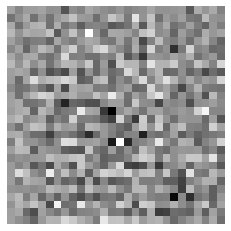

[[0.48776183]]


In [27]:
import matplotlib.pyplot as plt
g1 = build_generator()
d1 = build_discriminator()
z = tf.random.normal([1,64])
fake_img = g1.predict(z)
print(z.shape, fake_img.shape)
plt.imshow(fake_img[0,:,:,0], cmap = 'gray')
plt.axis('off')
plt.show()
logit = d1.predict(fake_img)
print(logit)

In [28]:
# GAN

def build_gan(z_dim, img_shape) :
  generator = build_generator(z_dim, img_shape)
  discriminator = build_discriminator(img_shape)
  z = layers.Input(shape = [z_dim])
  fake_img = generator(z)
  logit = discriminator(fake_img)
  return models.Model(z, logit, name = 'GAN')

gan = build_gan(128,(32,32,3))
gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128)]             0         
                                                                 
 Generator (Functional)      (None, 32, 32, 3)         1267203   
                                                                 
 Discriminator (Functional)  (None, 1)                 217985    
                                                                 
Total params: 1,485,188
Trainable params: 1,484,804
Non-trainable params: 384
_________________________________________________________________


### **l 데이터**

In [29]:
def get_mnist(batch_size = 32) :
  (x_train, _), (_,_) = tf.keras.datasets.mnist.load_data()
  x_train = x_train / 255.
  x_train = np.expand_dims(x_train, 3)
  ds = tf.data.Dataset.from_tensor_slices(x_train)
  ds = ds.batch(batch_size, drop_remainder = True).prefetch(1)
  print('x_train : ', x_train.shape)

  return ds
ds = get_mnist()


x_train :  (60000, 28, 28, 1)


### **| 학습**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-01.PNG?raw=true' width=600>
</p>

In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
epochs = 1
noise_dims = 100
batch_size = 32
for epoch in range(epochs) :
  for real_imgs in ds : # 20000중 32개씩
    noises = tf.random.normal(shape = [batch_size, noise_dims]) # p (가우시안 확률분포)
    # real_imgs : 이미 정의 되어 있음.
    print('z : ', noises.shape)
    print('x : ', real_imgs.shape)
    break

z :  (32, 100)
x :  (32, 28, 28, 1)


In [32]:
ones = tf.constant([1.], shape = [batch_size, 1])
zeros = tf.constant([0.], shape = [batch_size, 1])
ones.shape, zeros.shape

(TensorShape([32, 1]), TensorShape([32, 1]))

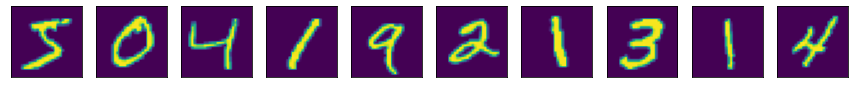

In [34]:
def display_sample_img(samples, cmap='gray_r'):
  plt.figure(figsize=(15,3))
  for i,sample in enumerate(samples):
    #sample = ( sample  + 1. ) / 2.
    #sample = np.clip(sample, 0, 1)
    if i==10:break
    plt.subplot(1,10,i+1)
    if sample.shape[-1]==1: plt.imshow(sample[:,:,0], cmap=cmap)
    else: plt.imshow(sample)
    plt.xticks([]);plt.yticks([])
  plt.show()
display_sample_img(x_train[:10])

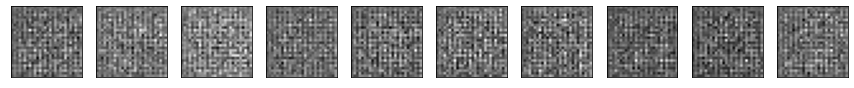

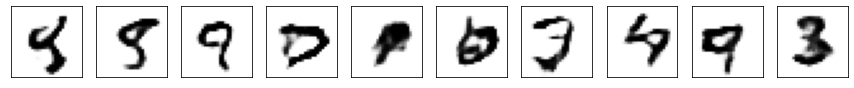

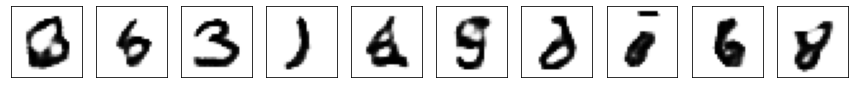

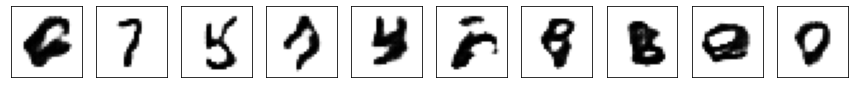

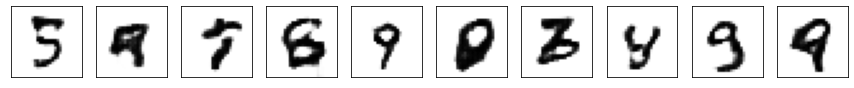

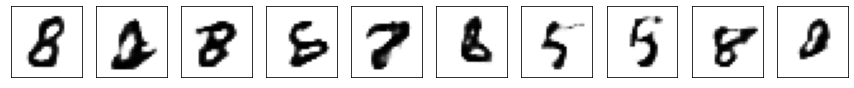

In [39]:
epochs = 5
noise_dims = 100
batch_size = 32
ones = tf.constant([1.], shape = [batch_size, 1])
zeros = tf.constant([0.], shape = [batch_size, 1])
img_shape = (28,28,1)

# 모델 생성
G = build_generator(noise_dims, img_shape)
D = build_discriminator(img_shape)

# 컴파일
loss = 'binary_crossentropy'
optimizer = 'adam'
D.compile(loss = loss, optimizer = optimizer)
D.trainable = False
input_noises = layers.Input(shape = noise_dims)
fake_img = G(input_noises)
logit = D(fake_img)
GAN = models.Model(input_noises, logit)
GAN.compile(loss = loss, optimizer = optimizer)

for epoch in range(epochs+1) :
  if epoch != 0 :
    for real_imgs in ds : # 20000중 32개씩
      noises = tf.random.normal(shape = [batch_size, noise_dims]) # p (가우시안 확률분포)
      fake_imgs = G.predict_on_batch(noises)

      # phase 1. 판별자 훈련
      D.trainable = True
      # 진짜 이미지 (real_imgs)가 들어오면 1, 가짜 이미지 (fake_imgs)가 들어오면 0 출력
      D_loss_real = D.train_on_batch(real_imgs, ones)
      D_loss_fake = D.train_on_batch(fake_imgs, zeros)
      D_loss = (0.5 * D_loss_real + 0.5 * D_loss_fake ) / float(batch_size)

    
      # phase 2. 생성자 훈련
      D.trainable = False
      noises = tf.random.normal(shape = [batch_size, noise_dims])
      G_loss = GAN.train_on_batch(noises, ones)

  fake_imgs = G.predict(noises)
  display_sample_img(fake_imgs[:10])

In [41]:
def get_fashion_mnist(batch_size = 32) :
  (x_train, _), (_,_) = tf.keras.datasets.fashion_mnist.load_data()
  x_train = x_train / 255.
  x_train = np.expand_dims(x_train, 3)
  ds = tf.data.Dataset.from_tensor_slices(x_train)
  ds = ds.batch(batch_size, drop_remainder = True).prefetch(1)
  print('x_train : ', x_train.shape)

  return ds
ds = get_fashion_mnist()


4431872/4422102 [==============================] - 0s 0us/step
x_train :  (60000, 28, 28, 1)


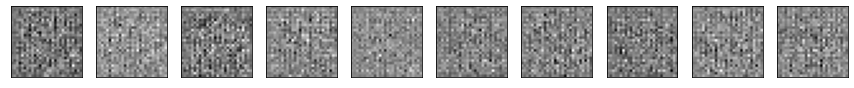

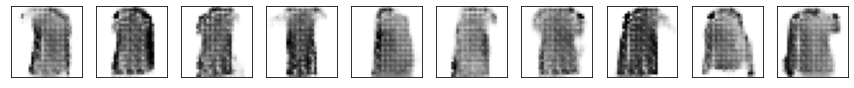

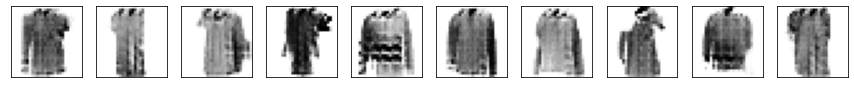

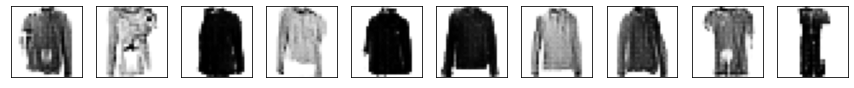

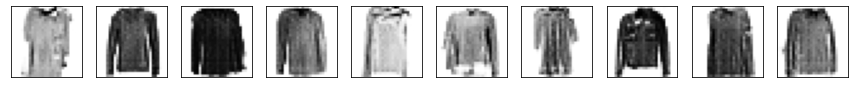

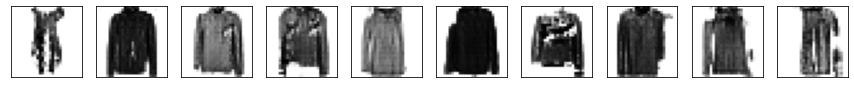

In [42]:
epochs = 5
noise_dims = 100
batch_size = 32
ones = tf.constant([1.], shape = [batch_size, 1])
zeros = tf.constant([0.], shape = [batch_size, 1])
img_shape = (28,28,1)

# 모델 생성
G = build_generator(noise_dims, img_shape)
D = build_discriminator(img_shape)

# 컴파일
loss = 'binary_crossentropy'
optimizer = 'adam'
D.compile(loss = loss, optimizer = optimizer)
D.trainable = False
input_noises = layers.Input(shape = noise_dims)
fake_img = G(input_noises)
logit = D(fake_img)
GAN = models.Model(input_noises, logit)
GAN.compile(loss = loss, optimizer = optimizer)

for epoch in range(epochs+1) :
  if epoch != 0 :
    for real_imgs in ds : # 20000중 32개씩
      noises = tf.random.normal(shape = [batch_size, noise_dims]) # p (가우시안 확률분포)
      fake_imgs = G.predict_on_batch(noises)

      # phase 1. 판별자 훈련
      D.trainable = True
      # 진짜 이미지 (real_imgs)가 들어오면 1, 가짜 이미지 (fake_imgs)가 들어오면 0 출력
      D_loss_real = D.train_on_batch(real_imgs, ones)
      D_loss_fake = D.train_on_batch(fake_imgs, zeros)
      D_loss = (0.5 * D_loss_real + 0.5 * D_loss_fake ) / float(batch_size)

    
      # phase 2. 생성자 훈련
      D.trainable = False
      noises = tf.random.normal(shape = [batch_size, noise_dims])
      G_loss = GAN.train_on_batch(noises, ones)

  fake_imgs = G.predict(noises)
  display_sample_img(fake_imgs[:10])